In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pylab as plt
plt.style.use('ggplot')

from functions.distance import get_distance, norm_features, split_random
from functions.datacleaning import MoscowHousing as mh

# Moscow Housing Project

Variables (column names):

Combining the building and apartment dataset gives 33 columns

Few or no missing data in both training and test set:

    - building_id ...... identify building and location
    - id ............... identify apartment
    - area_total ....... square meter of apartment
    - floor ............ at which floor the apartment is on
    - stories .......... total number of stories in building
    - rooms ............ number of rooms in apartment
    - new .............. if apartment is new or not
    - latitude ......... of building
    - longitude ........ of building
    - district ......... in which district the building is
    - street ........... street the building is on
    - address .......... location in street
    - constructed ...... year

Some missing data:

    - condition ........ range from 1-3 of apartments condition
    - elevator_without . elevator or not
    - elevator_passenger elevators for passengers or not
    - elevator_service . elevators for service or not
    - area_kitchen ..... size of kitchen in square meters
    - area_living ...... size of living room in square meters
    - layout ........... if prints of layout is available
    - bathrooms_shared . number of bathrooms shared
    - bathrooms_private. number of bathrooms that are private
    - windows_court .... windows in apartment facing a court
    - windows_street ... windows in apartment facing the street
    - phones ........... number of phone numbers connected to apartment
    - material ......... main type of material in building construction
    - parking .......... number of places for parking linked to apartment
    - garbage_chute .... garbage chute or not
    - heating .......... type of heating

About half missing data:

    - balconies ........ number of balconies in apartment
    - loggias .......... number of loggias in apartment
    - seller ........... seller category?
    - ceiling .......... height of ceiling in apartment in meters

Added variables:

- price_per_square_meter .... price/area_total in testing set


NaNs

floats are default set as NaN by pandas
categorical variables missing is set to -9 in prepared dataset

Initial datasets
- Train examples: 23285
- Train columns: 19 + 16 = 35 (id for building x 2)
- Test examples: 9937 (removed one)

In [2]:
features_all_s = ["building_id", "id_y", "seller", "area_total", 
                "area_kitchen", "area_living", "floor", "rooms", 
                "layout", "ceiling", "bathrooms_shared", 
                "bathrooms_private", "windows_court", "windows_street", 
                "balconies", "loggias", "condition", "phones", "new", "latitude", 
                "longitude", "district", "street", "address", "constructed",
                "material", "stories", "elevator_without", "elevator_passenger",
                "elevator_service", "parking", "garbage_chute", "heating"]

features_all = ["building_id", "id", "seller", "area_total", 
                "area_kitchen", "area_living", "floor", "rooms", 
                "layout", "ceiling", "bathrooms_shared", 
                "bathrooms_private", "windows_court", "windows_street", 
                "balconies", "loggias", "condition", "phones", "new", "latitude", 
                "longitude", "district", "street", "address", "constructed",
                "material", "stories", "elevator_without", "elevator_passenger",
                "elevator_service", "parking", "garbage_chute", "heating"]

features_float = ["area_total", "area_kitchen", "area_living", "ceiling"]

In [3]:
XTrainD = pd.read_csv("../data/apartments_and_building_train.csv")
XTestD = pd.read_csv("../data/apartments_and_building_test.csv")

df2 = pd.read_csv("../data/apartments_test.csv")
df1 = pd.read_csv("../data/buildings_test.csv")
XTestEXTRA = pd.merge(df1, df2, how='left', left_on=["id"], right_on=["building_id"])

XTestEXTRA.drop(["id_x"], axis=1)

XTestEXTRA = XTestEXTRA[features_all_s]

YTrain = XTrainD["price"]
XTrain = XTrainD[features_all].copy()
XTest = XTestD[features_all].copy()

In [4]:
XTestEXTRA.head()

,building_id,id_y,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,6659,32952,0.0,42.00,5.3,26.2,1.0,2.0,1.0,2.65,...,3К3,1962.0,0.0,8.0,0.0,1.0,0.0,NaN,1.0,0.0
1,369,23306,NaN,38.50,10.0,16.0,1.0,1.0,NaN,NaN,...,к2,2020.0,NaN,15.0,0.0,1.0,1.0,1.0,NaN,NaN
2,369,28079,3.0,70.78,11.5,39.1,10.0,2.0,NaN,NaN,...,к2,2020.0,NaN,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,369,28202,3.0,50.16,6.2,28.5,8.0,2.0,NaN,NaN,...,к2,2020.0,NaN,15.0,0.0,1.0,1.0,1.0,NaN,NaN
4,369,28489,3.0,50.16,6.2,28.5,9.0,2.0,NaN,NaN,...,к2,2020.0,NaN,15.0,0.0,1.0,1.0,1.0,NaN,NaN


In [5]:
XTestEXTRA.fillna(-9, inplace=True)
# Change datatypes

XTestEXTRA = XTestEXTRA.astype({"building_id":np.int64, "id_y":np.int64,
                                "seller":np.int64, "floor":np.int64,
                                "rooms":np.int64, "layout":np.int64,
                                "bathrooms_shared":np.int64, 
                                "bathrooms_private":np.int64,
                                "windows_court":np.int64,
                                "windows_street":np.int64,
                                "balconies":np.int64, "loggias":np.int64,
                                "condition":np.int64, "phones":np.int64,
                                "new":np.int64, "district":np.int64,
                                "constructed":np.int64, "material":np.int64,
                                "stories":np.int64, "elevator_without":np.int64,
                                "elevator_passenger":np.int64,
                                "elevator_service":np.int64, "parking":np.int64,
                                "garbage_chute":np.int64, "heating":np.int64})

XTestEXTRA = XTestEXTRA.rename(columns = {"id_y": "id"})
XTestEXTRA.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,6659,32952,0,42.00,5.3,26.2,1,2,1,2.65,...,3К3,1962,0,8,0,1,0,-9,1,0
1,369,23306,-9,38.50,10.0,16.0,1,1,-9,-9.00,...,к2,2020,-9,15,0,1,1,1,-9,-9
2,369,28079,3,70.78,11.5,39.1,10,2,-9,-9.00,...,к2,2020,-9,15,0,1,1,1,-9,-9
3,369,28202,3,50.16,6.2,28.5,8,2,-9,-9.00,...,к2,2020,-9,15,0,1,1,1,-9,-9
4,369,28489,3,50.16,6.2,28.5,9,2,-9,-9.00,...,к2,2020,-9,15,0,1,1,1,-9,-9


In [6]:
Xrow_original = XTestEXTRA[XTestEXTRA["building_id"] == 4202]

Xrow = Xrow_original.copy()
Xrow.loc[Xrow["district"] == -9, "district1"] = 12
del Xrow["district"]
Xrow = Xrow.rename(columns = {"district1": "district"})
Xrow.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,district
6801,4202,25814,2,30.3,-9.0,-9.0,1,1,-9,-9.0,...,2016,-9,3,-9,-9,-9,-9,-9,-9,12.0


In [7]:
Xrow["district"].head()

6801    12.0
Name: district, dtype: float64

In [8]:
XTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9936 entries, 0 to 9935
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   building_id         9936 non-null   int64  
 1   id                  9936 non-null   int64  
 2   seller              9936 non-null   int64  
 3   area_total          9936 non-null   float64
 4   area_kitchen        7704 non-null   float64
 5   area_living         7918 non-null   float64
 6   floor               9936 non-null   int64  
 7   rooms               9936 non-null   int64  
 8   layout              9936 non-null   int64  
 9   ceiling             4919 non-null   float64
 10  bathrooms_shared    9936 non-null   int64  
 11  bathrooms_private   9936 non-null   int64  
 12  windows_court       9936 non-null   int64  
 13  windows_street      9936 non-null   int64  
 14  balconies           9936 non-null   int64  
 15  loggias             9936 non-null   int64  
 16  condit

In [9]:
XTest = XTest.append([Xrow], ignore_index=True)

In [10]:
XTest.shape

(9937, 33)

In [11]:
XTrain = XTrain.replace(-9, np.NaN)
XTest = XTest.replace(-9, np.NaN)
XTrain = XTrain.replace(-9., np.NaN)
XTest = XTest.replace(-9., np.NaN)

In [12]:
XTrain.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,18450,NaN,73.8,9.0,47.0,1,3,1.0,NaN,...,4АК3,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN
1,1,20065,1.0,42.0,10.0,20.0,5,1,NaN,NaN,...,2305А,2015.0,2.0,17,0.0,1.0,1.0,1.0,1.0,0.0
2,2,2137,0.0,75.0,10.0,55.0,3,3,1.0,2.64,...,13,1987.0,3.0,12,0.0,1.0,0.0,1.0,1.0,0.0
3,3,4155,1.0,59.0,NaN,NaN,2,2,NaN,NaN,...,5К2,1996.0,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0
4,3,8798,1.0,59.0,12.0,30.5,2,2,1.0,2.60,...,5К2,1996.0,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0


In [13]:
XTrain[features_float] = norm_features(XTrain[features_float])
XTest[features_float] = norm_features(XTest[features_float])

# Set target
Y_Train = norm_features(YTrain)

# Remove column
#XTrain = XTrain.drop(["countpattern_street"], axis=1)

# Add distance calculations
XTrain["distance"] = XTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance(x.latitude, x.longitude), axis=1)
XTest["distance"] = XTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance(x.latitude, x.longitude), axis=1)

XTrain["distance"] = norm_features(XTrain["distance"])
XTest["distance"] = norm_features(XTest["distance"])

XTrain["price_per_square_meter"] = YTrain.values/(1.0 * XTrain["area_total"].values)
XTrain["price_per_square_meter"] = norm_features(XTrain["price_per_square_meter"])

features_final = ["area_total", 
                  "distance", "rooms", "floor",
                  "district"]
# Keep a copy to avoid having to load data for new tests
X_Train = XTrain.copy()
X_Test = XTest.copy()

In [14]:
Xrow["district"].head()

6801    12.0
Name: district, dtype: float64

In [15]:
features_all = ["building_id", "id", "seller", "area_total", 
                "area_kitchen", "area_living", "floor", "rooms", 
                "layout", "ceiling", "bathrooms_shared", 
                "bathrooms_private", "windows_court", "windows_street", 
                "balconies", "loggias", "phones", "new", "latitude", 
                "longitude", "district", "street", "address", "constructed",
                "material", "stories", "elevator_without", "elevator_passenger",
                "elevator_service", "parking", "garbage_chute", "heating"]

In [16]:
print(XTest.shape)

(9937, 34)


In [17]:
X_Train.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,price_per_square_meter
0,0,18450,NaN,-0.011096,-0.541037,0.263027,1,3,1.0,NaN,...,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,-0.315749,-0.674441
1,1,20065,1.0,-0.553098,-0.388730,-0.596888,5,1,NaN,NaN,...,2.0,17,0.0,1.0,1.0,1.0,1.0,0.0,2.903551,-0.009788
2,2,2137,0.0,0.009357,-0.388730,0.517816,3,3,1.0,-0.058168,...,3.0,12,0.0,1.0,0.0,1.0,1.0,0.0,-0.051469,0.959363
3,3,4155,1.0,-0.263348,NaN,NaN,2,2,NaN,NaN,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,0.304723,-0.026652
4,3,8798,1.0,-0.263348,-0.084116,-0.262477,2,2,1.0,-0.061871,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,0.304723,-0.026652


In [18]:
X_Test.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance
0,4,26052,NaN,5.675295,NaN,NaN,3,6,NaN,NaN,...,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,0.293752
1,5,29404,1.0,-0.896821,-1.581108,-0.588336,1,1,NaN,-0.077026,...,1982.0,3.0,12,0.0,1.0,0.0,NaN,1.0,NaN,0.116589
2,6,24089,2.0,0.494253,-0.417982,0.678815,3,4,1.0,-0.068230,...,2002.0,3.0,22,0.0,1.0,1.0,1.0,1.0,0.0,-0.040901
3,11,24033,0.0,0.087932,0.163582,0.165921,11,3,NaN,NaN,...,2001.0,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,0.074818
4,11,32976,1.0,0.096804,-0.316208,0.368062,5,3,1.0,NaN,...,2001.0,3.0,17,0.0,1.0,1.0,NaN,1.0,0.0,0.074818


In [19]:
Y_Train.head()

0   -0.232813
1   -0.312594
2   -0.189123
3   -0.255607
4   -0.255607
Name: price, dtype: float64

In [20]:
X_Train.head()

,building_id,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,...,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance,price_per_square_meter
0,0,18450,NaN,-0.011096,-0.541037,0.263027,1,3,1.0,NaN,...,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,-0.315749,-0.674441
1,1,20065,1.0,-0.553098,-0.388730,-0.596888,5,1,NaN,NaN,...,2.0,17,0.0,1.0,1.0,1.0,1.0,0.0,2.903551,-0.009788
2,2,2137,0.0,0.009357,-0.388730,0.517816,3,3,1.0,-0.058168,...,3.0,12,0.0,1.0,0.0,1.0,1.0,0.0,-0.051469,0.959363
3,3,4155,1.0,-0.263348,NaN,NaN,2,2,NaN,NaN,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,0.304723,-0.026652
4,3,8798,1.0,-0.263348,-0.084116,-0.262477,2,2,1.0,-0.061871,...,2.0,7,0.0,1.0,1.0,NaN,NaN,0.0,0.304723,-0.026652


In [21]:
X, y = X_Train[features_final].copy(), Y_Train.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
X.head()

,area_total,distance,rooms,floor,district
0,-0.011096,-0.315749,3,1,3
1,-0.553098,2.903551,1,5,9
2,0.009357,-0.051469,3,3,2
3,-0.263348,0.304723,2,2,3
4,-0.263348,0.304723,2,2,3


In [23]:
YTrain.head()

0    11300000.0
1     7100000.0
2    13600000.0
3    10100000.0
4    10100000.0
Name: price, dtype: float64

# Random Forest

In [24]:
X, y = X_Train[features_final].copy(), Y_Train.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
modelRandomForest = RandomForestRegressor(
    n_estimators=100,
    criterion='mse',
    max_depth=None,
    #min_samples_split=2,
    #min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

"""
Default from Ensemble gives --------------> mse 0.19
"""

'\nDefault from Ensemble gives --------------> mse 0.19\n'

In [26]:
modelRandomForest.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
rf_prediction = modelRandomForest.predict(X_test)

Text(0, 0.5, 'Ground Truth')

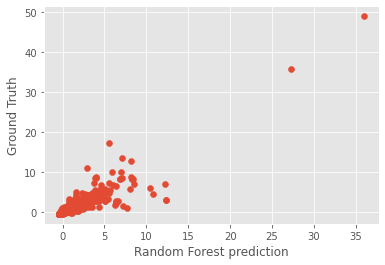

In [28]:
plt.scatter(rf_prediction, y_test)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

# Importance of Features

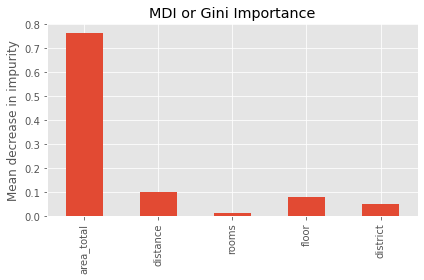

In [29]:
importances = modelRandomForest.feature_importances_
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("MDI or Gini Importance")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [30]:
# Current best mse is 0.19 (used for Kaggle)
rf_mse = round(mean_squared_error(rf_prediction, y_test), 2)
print('Test MSE:', rf_mse)

Test MSE: 0.19


In [31]:
# z-scores
print(rf_prediction)
print(rf_prediction.max())
print(rf_prediction.min())
print(rf_prediction.argmax())

[-0.15799423 -0.21922212 -0.15558302 ...  0.84649151 -0.26042498
 -0.1971416 ]
35.91397794492268
-0.40730478067980386
6067


In [32]:
# Get back to the original data for price (from z-score)
m = XTrainD["price"].mean()
print(m)
sd = XTrainD["price"].std()
print(sd)
print(m + rf_prediction * sd)

23556173.4710758
52643927.810737364
[15238736.49       12015460.         15365671.95666666 ...
 68118811.47000001  9846379.76333332 13177865.45000001]


In [33]:
X1, y1 = X_Train[features_final], Y_Train

In [34]:
modelRandomForest.fit(X1, y1)

RandomForestRegressor(random_state=42)

In [35]:
X_Test[features_final].head()

,area_total,distance,rooms,floor,district
0,5.675295,0.293752,6,3,8.0
1,-0.896821,0.116589,1,1,1.0
2,0.494253,-0.040901,4,3,2.0
3,0.087932,0.074818,3,11,2.0
4,0.096804,0.074818,3,5,2.0


In [36]:
rf_prediction1 = modelRandomForest.predict(X_Test[features_final])

In [37]:
print(m + rf_prediction1 * sd)

[1.81107097e+08 4.30432754e+06 1.75871979e+07 ... 1.18971029e+07
 1.07170948e+07 3.35887081e+06]


In [38]:
price_prediction_1 = m + (rf_prediction1 * sd)

In [39]:
print(price_prediction_1.shape)

(9937,)


In [40]:
result = pd.DataFrame(price_prediction_1)
result.head()
result["id"] = XTest["id"]
result["price_prediction"] = result.iloc[:,0]
result = result.iloc[:,1:]
result.head()

,id,price_prediction
0,26052,1.811071e+08
1,29404,4.304328e+06
2,24089,1.758720e+07
3,24033,1.520463e+07
4,32976,1.535471e+07


In [41]:
# Score on Kaggle: 0.3351 beats first level Gorbachev 0.34110
pd.DataFrame(result).to_csv("price_pred_1.csv", index=False)

# New round with other features

In [42]:
features = ["area_total", "distance", "distance_metro", 
            "floor", "district"]

data = mh()
XTrain, YTrain = data.get_data_train()
XTest = data.get_data_test()

X_Train = XTrain.copy()
X_Test = XTest.copy()
Y_Train = YTrain.copy()

X, y = X_Train[features].copy(), Y_Train.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)